# Preparations

In [119]:
import pandas as pd
import folium
import analysis
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import curve_fit
import numpy as np

import matplotlib.pyplot as plt

sns.set_theme(context="paper", style="white")

In [2]:
def plotregion(m, df, linecolor="#00ff00"):
    df = df.dropna(subset=["temp", "water"])
    line = df[["lat", "lon"]].values
    if len(line):
        folium.PolyLine(line, color=linecolor).add_to(m)

    for lat, lon, temp, humidity, distance, fixtype in df[
        ["lat", "lon", "temp", "water", "distance", "fixtype"]
    ].values:
        # color = f'#{int(temp / 20 * 256):02x}00{int(humidity / 100 * 256):02x}'
        # color = f'#{int(distance / 151 * 255):02x}00{int((1 - distance / 151) * 255):02x}'
        # color = 'black'
        color = (
            "orange"
            if fixtype == "DGPS"
            else "blue" if fixtype == "GPS" else "white"
        )
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            fill_opacity=1,
            fill=True,
            stroke=False,
            color=color,
        ).add_to(m)

In [3]:
def showmap(dates, transects=range(1, 4)):
    m = folium.Map(
        tiles="Stadia.AlidadeSatellite",
        location=[42.446, -78.2155],
        zoom_start=18,
        zoom_control=False,
    )
    for date in dates:
        for transect in transects:
            ground = analysis.load_ground(date, transect)
            below = analysis.load_MATH_data(date, transect, "below")
            above = analysis.load_MATH_data(date, transect, "above")

            below = analysis.below_distances(below, ground)
            above = analysis.above_distances(
                above, calibrate_time=pd.to_timedelta("0 seconds")
            )

            plotregion(m, below, linecolor="gold")
            plotregion(m, above, linecolor="purple")
    return m

In [4]:
showmap(["04-07"])

# Load Data

In [5]:
df = []
grounds = []
belows = []
aboves = []
for date in ["04-04", "04-07", "04-27"]:
    for transect in range(1, 4):
        grounds.append(
            analysis.normalize(analysis.load_ground(date, transect))
        )
        belows.append(
            analysis.normalize(
                analysis.below_distances(
                    analysis.load_MATH_data(date, transect, "below"),
                    grounds[-1],
                )
            )
        )
        aboves.append(
            analysis.normalize(
                analysis.above_distances(
                    analysis.load_MATH_data(date, transect, "above"),
                    calibrate_time=0,
                )
            )
        )
ground = pd.concat(grounds, ignore_index=True)
below = pd.concat(belows, ignore_index=True)
above = pd.concat(aboves, ignore_index=True)
df = pd.concat([ground, below, above], join="inner", ignore_index=True)
drone = pd.concat([above, below], ignore_index=True)

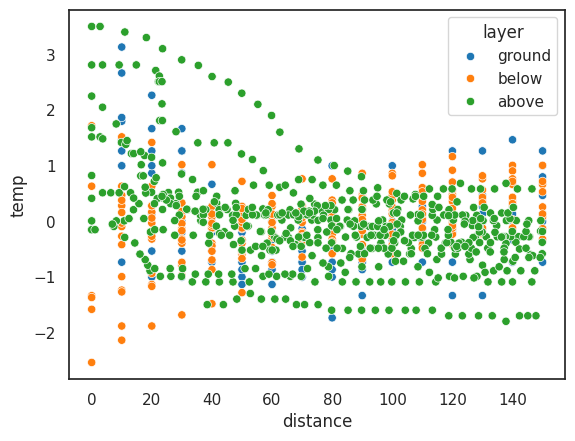

In [6]:
sns.scatterplot(df, x="distance", y="temp", hue="layer");

# Compare out/in

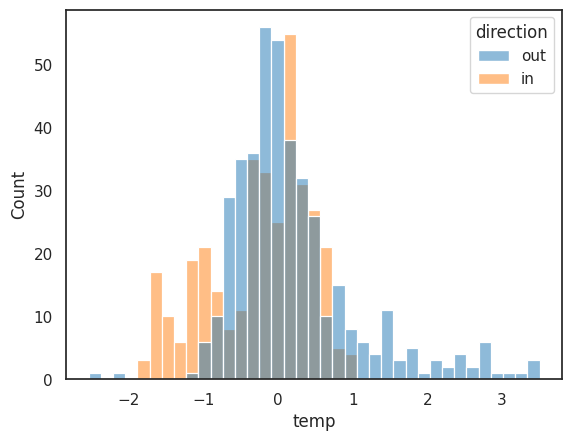

In [7]:
sns.histplot(drone, x="temp", hue="direction");

In [8]:
for layer in [above, below]:
    layer_out_temp = layer.query('direction == "out"')["temp"]
    layer_in_temp = layer.query('direction == "in"')["temp"]
    print(stats.f_oneway(layer_out_temp, layer_in_temp))

    print(layer_out_temp.mean() - layer_in_temp.mean())

F_onewayResult(statistic=np.float64(52.807139266543075), pvalue=np.float64(1.3279379792220867e-12))
0.5313736730173937
F_onewayResult(statistic=np.float64(8.41038208507579), pvalue=np.float64(0.004103971548012529))
0.2396311292734286


# Analysis

In [16]:
def predict(x, a, b, k):
    return (a - b) * np.exp(-x * k) + b

In [17]:
def r2(parameters, xs, ys):
    ypred = predict(xs, *parameters)
    ymean = ys.mean()
    ss_res = ((ys - ypred) ** 2).sum()
    ss_tot = ((ys - ymean) ** 2).sum()
    return 1 - ss_res / ss_tot

ground temp [ 3.70946639 -0.21031888  0.08075836] 0.30552259907316914
ground water [-2.85434849e+03  9.00022820e-03  9.96006655e-01] 0.00019211697883680934


/home/hopeful/.pyenv/versions/3.13.2/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hopeful/.pyenv/versions/3.13.2/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


below temp [-0.49138832  1.55058037  0.00380145] 0.16910989262664466
below water [ 0.36789748 -0.01057864  0.39650622] 0.002443899190798793
above temp [ 1.43935667 -0.39542765  0.02793073] 0.249824482187615
above water [-2.43200948  0.48212119  0.03604152] 0.133584572025358


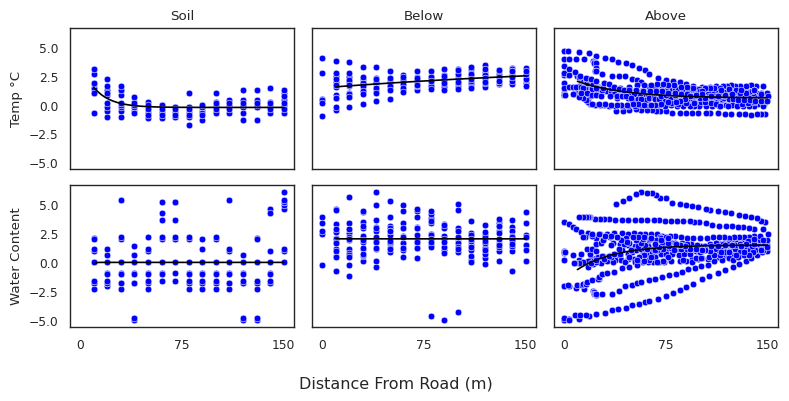

In [124]:
xs = np.linspace(10, 150)
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey="col")
fig.set_size_inches(8, 4)
fig.supxlabel("Distance From Road (m)")  # , y=0.07, x=0.533)
layer_stuff = [
    ("ground", ground, "brown"),
    ("below", below, "green"),
    ("above", above, "blue"),
]
for col, (name, layer, _) in enumerate(layer_stuff):
    for row, (var, color) in enumerate([("temp", "red"), ("water", "blue")]):
        if row == 0:
            axes[row, col].set_title(
                "Soil" if name == "ground" else name.capitalize()
            )

        data = layer[["distance", var]].dropna()
        parameters, *_ = curve_fit(predict, data["distance"], data[var])
        print(
            name, var, parameters, r2(parameters, data["distance"], data[var])
        )

        sns.scatterplot(
            data, x="distance", y=var, color="blue", ax=axes[row, col]
        )
        axes[row, col].plot(xs, predict(xs, *parameters), color="black")

        axes[row, col].set_xlabel(None)
        axes[row, col].set_xticks([0, 75, 150])
        if col == 0:
            axes[row, col].set_ylabel(
                "Temp °C" if var == "temp" else "Water Content"
            )
        else:
            axes[row, col].set_ylabel(None)
            axes[row, col].set_yticks([])

# axes[1, 2].sharey(axes[1, 1])
plt.tight_layout()
fig.savefig("image.png", bbox_inches="tight", facecolor=(0, 0, 0, 0))